## Classifier: this model will be responsible for predicting the status of persons if they have low/high stress.

### Dataset: https://www.kaggle.com/datasets/ziya07/mental-health-monitor-using-wearable-iot-sensors/data

What we have in dataset:

    - EEG Frequency Bands: The values of different EEG frequency bands (delta, theta, alpha, beta) that reflect brain activity.
    - GSR Values: Electrodermal activity representing emotional arousal or stress levels.
    - Cognitive State: The state of the individual's cognitive engagement (Focused, Distracted, or Cognitive Overload).
    - Emotional State: The individual's emotional state, categorized as Calm, Anxious, or Stressed.
    - Student Demographics: Information about the student, including their ID, age, gender, and the session type (study, test, relaxation).
    - Session Duration: The duration of the session in minutes.
    - Environmental Context: The context of the environment (e.g., Quiet Room, Library, or Home).
    - Preprocessed Features: Features obtained after data preprocessing, such as ICA components and mean GSR values.
    - Target: A binary label (1: High Stress, 0: Low Stress) representing the target mental health condition for classification purposes.

    - Steps:
        - Handling dataset:
            - Remapping stringified features into binary reprasantation
            - Normalizing dataset [if necessary]
            - Splitting dataset into [%70 Training] [%20 Testing] [%10 Validation]
            - Convert dataset into tensor

### Model Architecture: [1D CNN] : we will use fully connected layers (Neural Network):
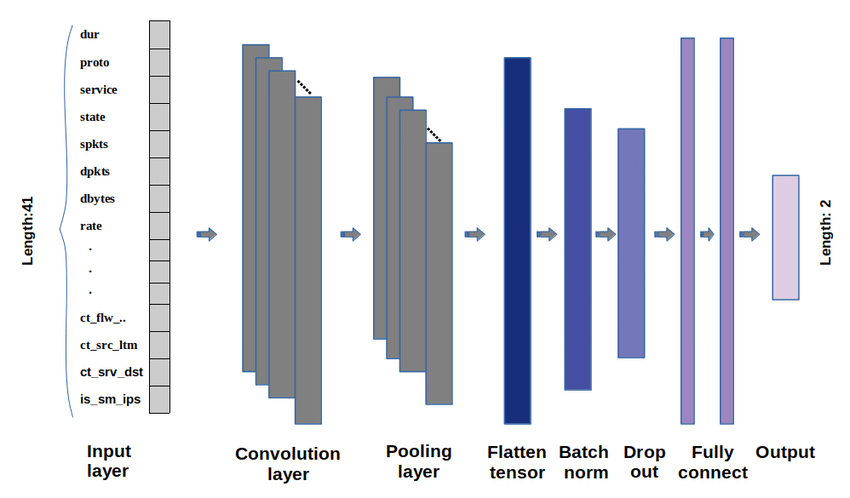

This architecture is inspired by the following paper:
(https://www.researchgate.net/figure/The-architecture-of-the-1D-CNN-simple-model-for-intrusion-detection-The-network-consists_fig1_340697891)
```
Input (GSR, EEG, HR ...)
   ↓
1D CNN (feature extraction)
   ↓
BatchNorm → ReLU → Dropout
   ↓
FullyConnecyedLayer → Softmax (32,1) -> Binary Classifer
```

##### Optimizer: SDG,
##### Loss Function: Binary Classification With Logits
##### Accuracy Function ```correct_ypreds / y_true * 100```

##### Training Loop: training step + validation step
##### Testing Model
##### Store the model into pth file
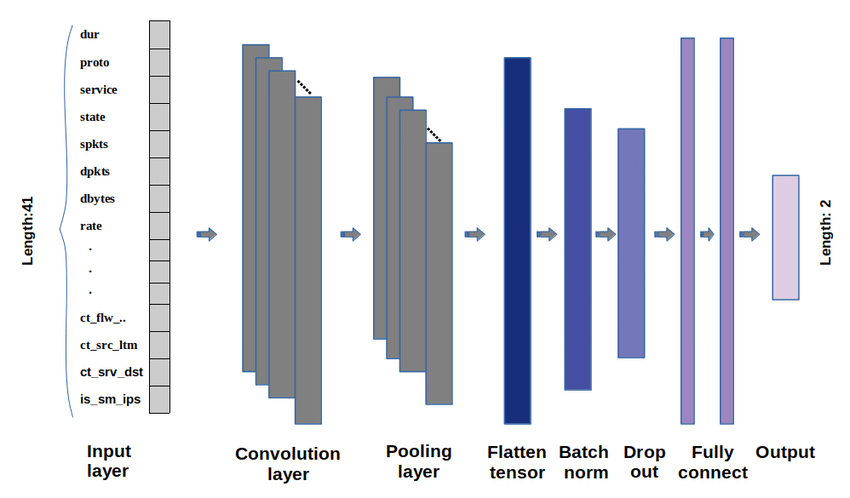

In [1017]:
import pathlib
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchsummary import summary

In [1018]:
dataset_path = pathlib.Path("datasets")

In [1019]:
#Downloading Dataset from kaggle
import os
import requests
from zipfile import ZipFile

dataset_path.mkdir(exist_ok=True, parents=True)

url = "https://www.kaggle.com/api/v1/datasets/download/ziya07/mental-health-monitor-using-wearable-iot-sensors"
filename = "samples.zip"

with open(dataset_path / filename, "wb") as file:
    req = requests.get(url)
    file.write(req.content)

# extract archived file
with ZipFile(dataset_path / filename, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

os.remove(dataset_path / filename)

print("Dataset downloaded")

Dataset downloaded


In [1020]:
# Read dataset using Pandas and convert it into numpy array
import pandas as pd

df = pd.read_csv(dataset_path / "mental_health_wearable_data.csv")
print(df.shape), print(df.columns)
df = df[:20]

(500, 13)
Index(['Timestamp', 'EEG_Frequency_Bands', 'GSR_Values', 'Cognitive_State',
       'Emotional_State', 'Student_ID', 'Age', 'Gender', 'Session_Type',
       'Duration (minutes)', 'Environmental_Context', 'Preprocessed_Features',
       'Target'],
      dtype='object')


In [1021]:
import ast
import time
from datetime import datetime


def parse_list(x):
    try:
        return list(map(float, ast.literal_eval(x)))
    except:
        return None


def avg_list(x):
    return sum(x) / len(x)


def ParseTimestamp(x):
    start_date = datetime.fromisoformat(x)
    return time.mktime(start_date.timetuple())

In [1022]:
### Remapping & cleaning

# Gender → 0/1
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
df["Cognitive_State"] = df["Cognitive_State"].map({"Distracted": 1.0, "Cognitive Overload": 2.0, "Focused": 0.0})
df["Emotional_State"] = df["Emotional_State"].map({"Anxious": 1.0, "Stressed": 2.0, "Calm": 0.0})
df["Session_Type"] = df["Session_Type"].map({"Study": 1.0, "Test": 2.0, "Relaxation": 0.0})

# EEG list + average
df["EEG_list"] = df["EEG_Frequency_Bands"].apply(
    lambda x: parse_list(x) if isinstance(x, str) and "[" in x else None
)
df["EEG_avg"] = df["EEG_list"].apply(
    lambda x: avg_list(x) if isinstance(x, list) and len(x) > 0 else None
)

# Preprocessed_Features → x1, x2
df["Preprocessed_Features"] = df["Preprocessed_Features"].apply(
    lambda x: parse_list(x) if isinstance(x, str) and "(" in x else None
)
df[["x1", "x2"]] = pd.DataFrame(df["Preprocessed_Features"].tolist(), index=df.index)

df = df.drop([
    # "GSR_Values",
    "Preprocessed_Features",
    "EEG_Frequency_Bands",
    "EEG_list",
    "Timestamp",
    "Student_ID",
    "Duration (minutes)",
    "Age",
    "EEG_avg",
    "Gender",
    # "Emotional_State",
    # "Session_Type",
    # "Cognitive_State",
    "Environmental_Context",
], axis=1)

df.head(n=500)


,GSR_Values,Cognitive_State,Emotional_State,Session_Type,Target,x1,x2
0,1.376494,1.0,1.0,1.0,0,0.092070,0.362187
1,0.084319,0.0,2.0,2.0,1,0.663030,0.165350
2,0.895629,2.0,1.0,2.0,1,0.010578,0.200443
3,0.386398,0.0,1.0,0.0,1,0.292492,0.877307
4,1.186898,0.0,1.0,0.0,0,0.767063,0.565267
5,1.397812,2.0,2.0,1.0,0,0.469185,0.660947
6,1.952754,2.0,1.0,2.0,1,0.412932,0.087264
7,1.327385,1.0,0.0,2.0,1,0.786125,0.578405
8,0.929081,2.0,2.0,2.0,0,0.402371,0.186206
9,1.767935,2.0,2.0,2.0,1,0.473626,0.121536


In [1023]:
cols = ["GSR_Values", "Cognitive_State", "Emotional_State", "Session_Type"]
dups = df.groupby(cols)["Target"].nunique()
conflicts = dups[dups > 1]
print(conflicts)

Series([], Name: Target, dtype: int64)


In [1024]:
feature_cols = ["GSR_Values", "Cognitive_State", "Emotional_State", "Session_Type"]

X_df = df[feature_cols]
y = df["Target"].values.astype("float32")
X = X_df.values.astype("float32")

num_features = X.shape[1]
X[3], y[3]

(array([0.38639838, 0.        , 1.        , 0.        ], dtype=float32),
 np.float32(1.0))

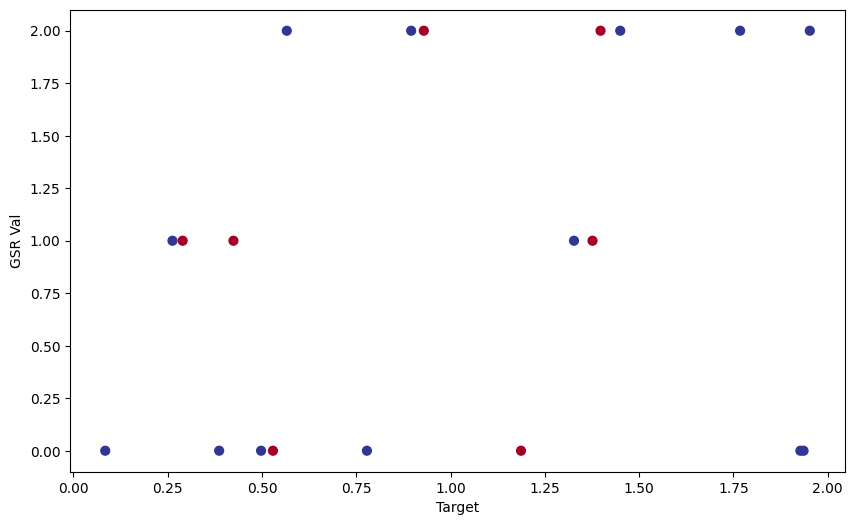

In [1025]:
# plotting

import matplotlib.pyplot as plt


def plot_data(x=X, labels=y):
    plt.figure(figsize=(10, 6))
    plt.scatter(x[:, 0], x[:, 1], c=labels, cmap="RdYlBu", s=40)
    # plt.scatter(labels, x[:, 1], c=labels, cmap="Greys_r", s=40)
    # plt.scatter(labels, x[:, 2], c=labels, cmap="vanimo", s=40)
    plt.xlabel("Target")
    plt.ylabel("GSR Val")


plot_data()

In [1026]:
df.corr()

,GSR_Values,Cognitive_State,Emotional_State,Session_Type,Target,x1,x2
GSR_Values,1.000000,0.253540,-0.112688,0.229412,0.149342,-0.286661,-0.240784
Cognitive_State,0.253540,1.000000,0.103535,0.266769,-0.042437,0.175082,-0.346708
Emotional_State,-0.112688,0.103535,1.000000,-0.201423,-0.187673,-0.176826,-0.219993
Session_Type,0.229412,0.266769,-0.201423,1.000000,-0.035382,-0.223139,-0.681422
Target,0.149342,-0.042437,-0.187673,-0.035382,1.000000,0.092336,0.191232
x1,-0.286661,0.175082,-0.176826,-0.223139,0.092336,1.000000,0.229415
x2,-0.240784,-0.346708,-0.219993,-0.681422,0.191232,0.229415,1.000000


In [1027]:
## Now let's split dataset
idx = int(len(X) * 0.9)

train_X, train_y = X[:idx], y[:idx]
test_X, test_y = X[idx:], y[idx:]

# tmp_idx = int(len(tmp_X) * 0.8)
# test_X, test_y = tmp_X[:tmp_idx], tmp_y[:tmp_idx]
# val_X, val_y = tmp_X[tmp_idx:], tmp_y[tmp_idx:]

len(train_X), len(test_X)

(18, 2)

In [1028]:
class WearableDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = WearableDataset(train_X, train_y)
test_ds = WearableDataset(test_X, test_y)
# val_ds = WearableDataset(val_X, val_y)

train_loader = DataLoader(dataset=train_ds, batch_size=100, shuffle=False)
# val_loader = DataLoader(dataset=val_ds, shuffle=False)
test_loader = DataLoader(dataset=test_ds, shuffle=False)

len(train_loader), len(test_loader)

(1, 2)

In [1029]:
## agnostic code to detect processor device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device

'mps'

In [1030]:
### Now let's create model architecture
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        )

    def forward(self, x):
        return self.net(x)


class StressCNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvBlock(in_ch=1, out_ch=32)
        self.conv_block2 = ConvBlock(in_ch=32, out_ch=64)
        # self.conv_block3 = ConvBlock(in_ch=64, out_ch=128)
        # self.conv_block4 = ConvBlock(in_ch=128, out_ch=256)

        flattened_dim = 64 * num_features

        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_dim, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # logits
        )

    def forward(self, x):
        x = x.unsqueeze(dim=1)  #[B, C, L] I've added channel dimension in position 1
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        # x = self.conv_block3(x)
        # x = self.conv_block4(x)
        return self.fc(x).squeeze(1)


class StressMLP(nn.Module):
    def __init__(self, num_features=num_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # logits
        )

    def forward(self, x):
        # x: [B, num_features]
        return self.net(x).squeeze(1)  # [B]


In [1031]:
model_01 = StressCNN1D()
model_01.state_dict()

OrderedDict([('conv_block1.net.0.weight',
              tensor([[[-0.3614, -0.2193, -0.4964]],
              
                      [[-0.0578, -0.5261, -0.4234]],
              
                      [[ 0.1196,  0.1486,  0.2906]],
              
                      [[-0.1901,  0.0079, -0.4483]],
              
                      [[ 0.5081, -0.1880,  0.3431]],
              
                      [[ 0.2321,  0.4342, -0.3428]],
              
                      [[-0.3998,  0.3070, -0.1437]],
              
                      [[ 0.2560,  0.3871,  0.2367]],
              
                      [[-0.1842,  0.5351,  0.1895]],
              
                      [[ 0.5165,  0.1539,  0.0946]],
              
                      [[ 0.4635, -0.1606,  0.1413]],
              
                      [[-0.2827, -0.1677, -0.0425]],
              
                      [[-0.5754, -0.0973, -0.1941]],
              
                      [[-0.4472,  0.2327,  0.4144]],
              
      

In [1032]:
summary(model_01, input_size=(num_features,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 32, 4]             128
       BatchNorm1d-2                [-1, 32, 4]              64
              ReLU-3                [-1, 32, 4]               0
           Dropout-4                [-1, 32, 4]               0
         ConvBlock-5                [-1, 32, 4]               0
            Conv1d-6                [-1, 64, 4]           6,208
       BatchNorm1d-7                [-1, 64, 4]             128
              ReLU-8                [-1, 64, 4]               0
           Dropout-9                [-1, 64, 4]               0
        ConvBlock-10                [-1, 64, 4]               0
          Flatten-11                  [-1, 256]               0
           Linear-12                   [-1, 32]           8,224
             ReLU-13                   [-1, 32]               0
           Linear-14                   

In [1033]:
## Loss function and Optimizer and Accuracy
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_01.parameters(), lr=0.0001)

In [1034]:
def accuracy_fn(ytrue, ypreds):
    ytrue = ytrue.view(-1)
    ypreds = ypreds.view(-1)
    correct = (ypreds == ytrue).sum().item()
    return correct / len(ytrue) * 100

In [1035]:
from timeit import default_timer as timer


def train_step(model: nn.Module,
               dataloader: DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device):
    total_loss, total_acc, num_batches = 0.0, 0.0, 0

    model.to(device)
    model.train()
    start_timer = timer()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device).float()

        # forward
        logits = model(X)

        # loss
        loss = loss_fn(logits, y)

        #acc
        ypreds = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(ytrue=y, ypreds=ypreds)

        # backward
        optimizer.zero_grad(set_to_none=True)

        loss.backward()
        optimizer.step()

        # metrics
        batch_loss = loss.item()
        total_loss += batch_loss
        total_acc += acc
        num_batches += 1

        # if batch % 10 == 0:
        # print(f"Batch {batch}: loss={batch_loss:.4f}, acc={acc:.4f}%")

    # averages
    total_loss /= num_batches
    total_acc /= num_batches
    end_timer = timer()
    total_time = end_timer - start_timer

    print(f"Epoch Train --> loss_avg={total_loss:.4f}, acc_avg={total_acc:.4f}% :: time={total_time:.2f}s")

    return {
        "loss": total_loss,
        "acc": total_acc,
        "time": total_time
    }

In [1036]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn=loss_fn,
              device=device,
              accuracy_fn=accuracy_fn,
              validation=False):
    total_loss, total_acc = 0.0, 0.0
    action = "Validating" if validation else "Testing"
    start_timer = timer()
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device).float()

            # forward
            logits = model(X)

            # loss
            loss = loss_fn(logits, y)

            #acc
            ypreds = torch.round(torch.sigmoid(logits))
            acc = accuracy_fn(ytrue=y, ypreds=ypreds)

            # metrics
            batch_loss = loss.item()

            total_loss += batch_loss
            total_acc += acc
            # print(f"{action} --> Loss: {loss:.2f} Acc: {acc:.2f}%")

    #calculate loss avg, accuracy avg
    total_loss /= len(dataloader)
    total_acc /= len(dataloader)

    end_timer = timer()
    total_time = end_timer - start_timer
    print(f"Epoch {action} --> loss_avg={total_loss:.4f} , acc_avg={total_acc:.4f}% :: time={total_time:.2f}s")

    return {
        "loss": total_loss,
        "acc": total_acc,
        "time": total_time
    }

In [1037]:
Xb, yb = next(iter(train_loader))
Xb, yb = Xb.to(device), yb.to(device).float()

model_01.to(device)
model_01.train()
optimizer.zero_grad()

logits_before = model_01(Xb)
loss_before = loss_fn(logits_before, yb)

loss_before.backward()
optimizer.step()

logits_after = model_01(Xb)
loss_after = loss_fn(logits_after, yb)

print("loss_before:", loss_before.item())
print("loss_after :", loss_after.item())


loss_before: 0.6726118922233582
loss_after : 0.67259281873703


In [1038]:
## training Loop

from tqdm import tqdm

training_steps = []
validation_steps = []

epochs = 10000

for epoch in tqdm(range(epochs), colour="green"):
    # ----- Training -----
    train_metrics = train_step(
        model=model_01,
        dataloader=train_loader,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        loss_fn=loss_fn,
        device=device
    )
    training_steps.append(train_metrics)

    # # ----- Validation -----
    # val_metrics = test_step(
    #     model=model_01,
    #     dataloader=val_loader,
    #     loss_fn=loss_fn,
    #     accuracy_fn=accuracy_fn,
    #     device=device,
    #     validation=True
    # )
    # validation_steps.append(val_metrics)

    model_dir = pathlib.Path("models")
    model_dir.mkdir(parents=True, exist_ok=True)

    torch.save(model_01.state_dict(), model_dir / "stress_cnn_1d.pth")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch Train --> loss_avg=0.6726, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6726, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6725, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6725, acc_avg=61.1111% :: time=0.01s


  0%|          | 8/10000 [00:00<02:06, 78.98it/s]

Epoch Train --> loss_avg=0.6725, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6724, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6724, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6724, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6724, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6724, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6723, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6723, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6723, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6722, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6722, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6721, acc_avg=61.1111% :: time=0.01s


  0%|          | 17/10000 [00:00<01:59, 83.42it/s]

Epoch Train --> loss_avg=0.6721, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6721, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6720, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6720, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6720, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6719, acc_avg=61.1111% :: time=0.00s


  0%|          | 27/10000 [00:00<01:54, 87.22it/s]

Epoch Train --> loss_avg=0.6720, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6718, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6718, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6718, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6717, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6717, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6716, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6716, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6716, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6714, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6715, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6715, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6714, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6714, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6714, acc_avg=61.1111% :: time=0.00s


  0%|          | 38/10000 [00:00<01:47, 92.96it/s]

Epoch Train --> loss_avg=0.6713, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6712, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6712, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6712, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6712, acc_avg=61.1111% :: time=0.01s


  0%|          | 48/10000 [00:00<01:50, 90.35it/s]

Epoch Train --> loss_avg=0.6711, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6712, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6711, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6710, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6710, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6709, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6707, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6708, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6708, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6706, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6705, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6706, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6704, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6704, acc_avg=61.1111% :: time=0.00s


  1%|          | 58/10000 [00:00<01:48, 91.40it/s]

Epoch Train --> loss_avg=0.6704, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6702, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6705, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6704, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6705, acc_avg=61.1111% :: time=0.00s


  1%|          | 68/10000 [00:00<01:46, 92.84it/s]

Epoch Train --> loss_avg=0.6701, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6700, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6699, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6696, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6698, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6699, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6697, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6698, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6696, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6695, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6692, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6693, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6693, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6688, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6689, acc_avg=61.1111% :: time=0.00s


  1%|          | 79/10000 [00:00<01:43, 95.51it/s]

Epoch Train --> loss_avg=0.6682, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6686, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6680, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6678, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6679, acc_avg=61.1111% :: time=0.00s


  1%|          | 89/10000 [00:00<01:45, 94.31it/s]

Epoch Train --> loss_avg=0.6679, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6673, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6673, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6675, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6672, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6681, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6665, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6668, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6660, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6656, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6654, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6638, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6655, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6644, acc_avg=61.1111% :: time=0.01s


  1%|          | 99/10000 [00:01<01:46, 92.86it/s]

Epoch Train --> loss_avg=0.6636, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6639, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6645, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6616, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6635, acc_avg=61.1111% :: time=0.01s


  1%|          | 109/10000 [00:01<01:49, 90.68it/s]

Epoch Train --> loss_avg=0.6623, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6617, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6616, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6612, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6577, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6568, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6557, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6563, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6534, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6539, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6504, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6472, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6505, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6510, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6476, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6431, acc_avg

  1%|▏         | 129/10000 [00:01<01:45, 93.54it/s]

Epoch Train --> loss_avg=0.6397, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6541, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6327, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6225, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6282, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6118, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6171, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.6188, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6123, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6162, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6262, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6164, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6092, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5979, acc_avg=61.1111% :: time=0.01s


  1%|▏         | 139/10000 [00:01<01:43, 95.24it/s]

Epoch Train --> loss_avg=0.6132, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.5994, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5942, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5956, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5800, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5862, acc_avg=61.1111% :: time=0.00s


  2%|▏         | 150/10000 [00:01<01:39, 98.61it/s]

Epoch Train --> loss_avg=0.5714, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5743, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5809, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5856, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5347, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5762, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5644, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5483, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5354, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5394, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5325, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5763, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5467, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5715, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5573, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5803, acc_avg

  2%|▏         | 171/10000 [00:01<01:38, 99.65it/s]

Epoch Train --> loss_avg=0.5632, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.5128, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5339, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4988, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5249, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5574, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5365, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5011, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5496, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5195, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5042, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5378, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4965, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4480, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5107, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5286, acc_avg

  2%|▏         | 192/10000 [00:02<01:37, 101.01it/s]

Epoch Train --> loss_avg=0.4561, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5104, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5458, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4844, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4945, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4924, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4946, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4836, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4955, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4554, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4225, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4376, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5187, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4024, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4368, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5169, acc_avg

  2%|▏         | 203/10000 [00:02<01:37, 100.75it/s]

Epoch Train --> loss_avg=0.4621, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4060, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4254, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4402, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3899, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4652, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4536, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4313, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3933, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4464, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4301, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4274, acc_avg=61.1111% :: time=0.00s


  2%|▏         | 214/10000 [00:02<01:36, 101.16it/s]

Epoch Train --> loss_avg=0.4069, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4736, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3946, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4759, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4367, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3968, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4048, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3796, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3979, acc_avg=61.1111% :: time=0.00s


  2%|▏         | 225/10000 [00:02<01:37, 100.72it/s]

Epoch Train --> loss_avg=0.3689, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4624, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3755, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4191, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4605, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4302, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4632, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4212, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4352, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4435, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5011, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4060, acc_avg=61.1111% :: time=0.00s


  2%|▏         | 236/10000 [00:02<01:35, 101.75it/s]

Epoch Train --> loss_avg=0.5410, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4395, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4180, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3986, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3787, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4512, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3994, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4119, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4602, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3640, acc_avg=61.1111% :: time=0.00s


  2%|▏         | 247/10000 [00:02<01:35, 102.56it/s]

Epoch Train --> loss_avg=0.3865, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4528, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4341, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4248, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4754, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.5024, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3997, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3756, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3814, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3775, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4445, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4002, acc_avg=61.1111% :: time=0.01s


  3%|▎         | 258/10000 [00:02<01:38, 99.06it/s] 

Epoch Train --> loss_avg=0.3790, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3829, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3479, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3831, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4301, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3864, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4342, acc_avg=61.1111% :: time=0.00s


  3%|▎         | 268/10000 [00:02<01:41, 95.69it/s]

Epoch Train --> loss_avg=0.4173, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3771, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.4456, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3566, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3993, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4367, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4508, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3878, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3343, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3790, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4223, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3249, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3316, acc_avg=61.1111% :: time=0.00s


  3%|▎         | 279/10000 [00:02<01:39, 98.14it/s]

Epoch Train --> loss_avg=0.3697, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.5394, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4288, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3604, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.6092, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4288, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3657, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4209, acc_avg=61.1111% :: time=0.01s


  3%|▎         | 289/10000 [00:03<01:39, 97.83it/s]

Epoch Train --> loss_avg=0.4606, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3522, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3807, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3380, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3677, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3745, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3939, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3860, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3483, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4053, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3207, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3515, acc_avg=61.1111% :: time=0.00s


  3%|▎         | 300/10000 [00:03<01:37, 99.21it/s]

Epoch Train --> loss_avg=0.4200, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3703, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3649, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3831, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.4147, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3921, acc_avg=61.1111% :: time=0.01s
Epoch Train --> loss_avg=0.3438, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3367, acc_avg=61.1111% :: time=0.00s
Epoch Train --> loss_avg=0.3104, acc_avg=72.2222% :: time=0.00s


  3%|▎         | 310/10000 [00:03<01:38, 97.89it/s]

Epoch Train --> loss_avg=0.3565, acc_avg=72.2222% :: time=0.00s
Epoch Train --> loss_avg=0.3064, acc_avg=72.2222% :: time=0.01s
Epoch Train --> loss_avg=0.3815, acc_avg=72.2222% :: time=0.01s
Epoch Train --> loss_avg=0.3250, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.4004, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3751, acc_avg=72.2222% :: time=0.00s
Epoch Train --> loss_avg=0.3392, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3964, acc_avg=72.2222% :: time=0.00s
Epoch Train --> loss_avg=0.3678, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.3469, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.3430, acc_avg=83.3333% :: time=0.00s


  3%|▎         | 321/10000 [00:03<01:37, 99.23it/s]

Epoch Train --> loss_avg=0.2997, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3282, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.3660, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.4338, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.2938, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3502, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3823, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.4608, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.4026, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.4528, acc_avg=88.8889% :: time=0.00s


  3%|▎         | 332/10000 [00:03<01:36, 99.82it/s]

Epoch Train --> loss_avg=0.4221, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3691, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.3618, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.3717, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.3124, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3569, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3104, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3912, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.3299, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3109, acc_avg=88.8889% :: time=0.00s


  3%|▎         | 342/10000 [00:03<01:37, 99.12it/s]

Epoch Train --> loss_avg=0.3671, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3048, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3510, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2812, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.4456, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.2987, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.2630, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2559, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2803, acc_avg=94.4444% :: time=0.00s


  4%|▎         | 352/10000 [00:03<01:37, 99.04it/s]

Epoch Train --> loss_avg=0.2949, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2924, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3076, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3668, acc_avg=72.2222% :: time=0.01s
Epoch Train --> loss_avg=0.2667, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.2854, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2444, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3031, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2548, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2344, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3424, acc_avg=83.3333% :: time=0.00s


  4%|▎         | 362/10000 [00:03<01:37, 98.81it/s]

Epoch Train --> loss_avg=0.3300, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3722, acc_avg=77.7778% :: time=0.01s
Epoch Train --> loss_avg=0.2709, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2624, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1882, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2834, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.3260, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.2654, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3136, acc_avg=88.8889% :: time=0.00s


  4%|▎         | 373/10000 [00:03<01:36, 100.25it/s]

Epoch Train --> loss_avg=0.3202, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2121, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.4018, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3025, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.2871, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.2135, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2212, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2516, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3460, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.2382, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2489, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2260, acc_avg=94.4444% :: time=0.00s


  4%|▍         | 384/10000 [00:03<01:34, 101.83it/s]

Epoch Train --> loss_avg=0.1863, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2953, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3470, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1429, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1905, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2523, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1544, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2691, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2290, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.2571, acc_avg=88.8889% :: time=0.00s


  4%|▍         | 395/10000 [00:04<01:33, 102.27it/s]

Epoch Train --> loss_avg=0.1775, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1331, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1441, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2895, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.1316, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3723, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3098, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1916, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1197, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2662, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1578, acc_avg=94.4444% :: time=0.00s


  4%|▍         | 406/10000 [00:04<01:33, 102.34it/s]

Epoch Train --> loss_avg=0.2467, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.2173, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2774, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.1950, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1229, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1488, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2310, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1598, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1894, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2828, acc_avg=83.3333% :: time=0.00s


  4%|▍         | 417/10000 [00:04<01:34, 101.63it/s]

Epoch Train --> loss_avg=0.0801, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2236, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1506, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2161, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.2731, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1706, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1260, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0742, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3885, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.0775, acc_avg=100.0000% :: time=0.00s


  4%|▍         | 428/10000 [00:04<01:33, 102.62it/s]

Epoch Train --> loss_avg=0.0739, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0858, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0735, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1408, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1697, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1362, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1646, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3469, acc_avg=88.8889% :: time=0.00s


  4%|▍         | 439/10000 [00:04<01:32, 103.15it/s]

Epoch Train --> loss_avg=0.0889, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0687, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1359, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0656, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0880, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2513, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0720, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1149, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1440, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1033, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2051, acc_avg=94.4444% :: time=0.00s


  4%|▍         | 450/10000 [00:04<01:32, 103.25it/s]

Epoch Train --> loss_avg=0.1368, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0680, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0821, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1145, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1954, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1078, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0766, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1423, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0878, acc_avg=100.0000% :: time=0.00s


  5%|▍         | 461/10000 [00:04<01:32, 103.53it/s]

Epoch Train --> loss_avg=0.1014, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1848, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.0989, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3028, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0562, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1595, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0502, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0605, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2666, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.3369, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0236, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1049, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1690, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0325, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0591, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1153, a

  5%|▍         | 472/10000 [00:04<01:36, 98.65it/s] 

Epoch Train --> loss_avg=0.1333, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0877, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0294, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0323, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1708, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0353, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1160, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1050, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0595, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1361, acc_avg=94.4444% :: time=0.01s


  5%|▍         | 482/10000 [00:04<01:39, 95.72it/s]

Epoch Train --> loss_avg=0.1550, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2166, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1687, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0531, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2998, acc_avg=83.3333% :: time=0.01s
Epoch Train --> loss_avg=0.1541, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0907, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1756, acc_avg=88.8889% :: time=0.00s


  5%|▍         | 492/10000 [00:05<01:43, 91.50it/s]

Epoch Train --> loss_avg=0.1019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1266, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0688, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0237, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0939, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1462, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1720, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.1941, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.6951, acc_avg=72.2222% :: time=0.00s
Epoch Train --> loss_avg=0.1025, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0811, acc_avg=94.4444% :: time=0.01s


  5%|▌         | 502/10000 [00:05<01:44, 91.25it/s]

Epoch Train --> loss_avg=0.1705, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1636, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1832, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0287, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0363, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0568, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1093, acc_avg=100.0000% :: time=0.01s


  5%|▌         | 512/10000 [00:05<01:45, 89.82it/s]

Epoch Train --> loss_avg=0.0501, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0324, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0908, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0489, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0835, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3498, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.0791, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0196, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0342, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0664, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0466, acc_avg=100.0000% :: time=0.01s


  5%|▌         | 522/10000 [00:05<01:44, 90.36it/s]

Epoch Train --> loss_avg=0.0461, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0633, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0637, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0796, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1302, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0193, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1657, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1292, acc_avg=94.4444% :: time=0.01s


  5%|▌         | 532/10000 [00:05<01:45, 89.99it/s]

Epoch Train --> loss_avg=0.0157, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0920, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0934, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0529, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0443, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1044, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0167, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0745, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0912, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0500, acc_avg=100.0000% :: time=0.01s


  5%|▌         | 542/10000 [00:05<01:46, 89.00it/s]

Epoch Train --> loss_avg=0.0384, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1576, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0222, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0686, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0223, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0800, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0204, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0682, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 552/10000 [00:05<01:45, 89.67it/s]

Epoch Train --> loss_avg=0.0783, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0409, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0239, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0438, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0800, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0225, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0299, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1296, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2636, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0181, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 562/10000 [00:05<01:43, 91.44it/s]

Epoch Train --> loss_avg=0.0176, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0142, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0508, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0397, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3191, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1412, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1025, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0209, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0436, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 572/10000 [00:05<01:40, 93.77it/s]

Epoch Train --> loss_avg=0.0685, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0466, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2064, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0176, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1071, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2923, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.0598, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0304, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0412, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0488, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1483, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0415, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 583/10000 [00:06<01:37, 96.38it/s]

Epoch Train --> loss_avg=0.0789, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1481, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1952, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1028, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0245, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0266, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1466, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0654, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0189, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 593/10000 [00:06<01:38, 95.31it/s]

Epoch Train --> loss_avg=0.0188, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0191, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0189, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0379, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0946, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0469, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0149, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0283, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1313, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0574, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0823, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 603/10000 [00:06<01:38, 95.19it/s]

Epoch Train --> loss_avg=0.0297, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0488, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0223, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0888, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1049, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0397, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0359, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0227, acc_avg=100.0000% :: time=0.00s


  6%|▌         | 614/10000 [00:06<01:36, 97.48it/s]

Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0174, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1303, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0116, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0206, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0225, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1568, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0340, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0709, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.01s


  6%|▋         | 625/10000 [00:06<01:35, 98.53it/s]

Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1536, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0199, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0189, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0191, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0327, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0896, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0991, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0777, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s


  6%|▋         | 636/10000 [00:06<01:33, 100.30it/s]

Epoch Train --> loss_avg=0.0263, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0254, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0641, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1322, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1016, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1115, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0121, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0296, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1124, acc_avg=94.4444% :: time=0.01s


  6%|▋         | 647/10000 [00:06<01:32, 100.77it/s]

Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0139, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0814, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0585, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1059, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1728, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1730, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1005, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0423, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0112, acc_avg=100.0000% :: time=0.00s


  7%|▋         | 658/10000 [00:06<01:33, 100.02it/s]

Epoch Train --> loss_avg=0.0214, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0116, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0800, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1331, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0283, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2593, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1301, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0458, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1587, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0339, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0993, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0365, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2255, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1747, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1744, 

  7%|▋         | 669/10000 [00:06<01:35, 97.47it/s] 

Epoch Train --> loss_avg=0.0312, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0123, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1732, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0108, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0226, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0195, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0548, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.01s


  7%|▋         | 679/10000 [00:07<01:35, 97.36it/s]

Epoch Train --> loss_avg=0.3012, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0677, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0143, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1578, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0267, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0592, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0955, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0543, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1821, acc_avg=88.8889% :: time=0.00s


  7%|▋         | 690/10000 [00:07<01:34, 98.64it/s]

Epoch Train --> loss_avg=0.1345, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1683, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0620, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0765, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1867, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1021, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0288, acc_avg=100.0000% :: time=0.00s


  7%|▋         | 701/10000 [00:07<01:34, 98.87it/s]

Epoch Train --> loss_avg=0.0330, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0778, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1196, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0435, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0290, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0488, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0211, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0245, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1681, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0361, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0466, acc_avg=100.0000% :: time=0.00s


  7%|▋         | 712/10000 [00:07<01:33, 99.61it/s]

Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3697, acc_avg=77.7778% :: time=0.00s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0684, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0383, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1445, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0287, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0183, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0136, acc_avg=100.0000% :: time=0.00s


  7%|▋         | 722/10000 [00:07<01:33, 99.31it/s]

Epoch Train --> loss_avg=0.0229, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0534, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0168, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0118, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0321, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0090, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0215, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0274, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3267, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0239, acc_avg=100.0000% :: time=0.00s


  7%|▋         | 733/10000 [00:07<01:33, 99.60it/s]

Epoch Train --> loss_avg=0.0558, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1613, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0245, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1800, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0965, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0170, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0487, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0355, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0935, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0146, acc_avg=100.0000% :: time=0.00s


  7%|▋         | 744/10000 [00:07<01:33, 99.47it/s]

Epoch Train --> loss_avg=0.0618, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0465, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1980, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.1705, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0311, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0142, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1264, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.2843, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s


  8%|▊         | 754/10000 [00:07<01:32, 99.43it/s]

Epoch Train --> loss_avg=0.0816, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0296, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0166, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0159, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1102, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0103, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0262, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2524, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s


  8%|▊         | 764/10000 [00:07<01:32, 99.55it/s]

Epoch Train --> loss_avg=0.0201, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0582, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0239, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0296, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2607, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0424, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0143, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0235, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0401, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0292, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0218, acc_avg=100.0000% :: time=0.00s


  8%|▊         | 774/10000 [00:07<01:32, 99.53it/s]

Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0194, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0172, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0551, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0634, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0309, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0755, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0183, acc_avg=100.0000% :: time=0.00s


  8%|▊         | 794/10000 [00:08<01:32, 99.36it/s]

Epoch Train --> loss_avg=0.0815, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1100, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1105, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1509, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0443, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0126, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0168, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0425, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1643, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0351, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0078, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1030, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.1072

  8%|▊         | 815/10000 [00:08<01:31, 100.93it/s]

Epoch Train --> loss_avg=0.0350, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0140, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0658, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0576, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0312, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0202, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0121, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2322, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0259, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0306, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0896, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0774, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0781, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0323, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0169

  8%|▊         | 826/10000 [00:08<01:31, 100.53it/s]

Epoch Train --> loss_avg=0.1675, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0308, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0269, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0838, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0348, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0175, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0136, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0173, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1834, acc_avg=88.8889% :: time=0.00s


  8%|▊         | 837/10000 [00:08<01:31, 100.39it/s]

Epoch Train --> loss_avg=0.4031, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.3153, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0077, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2004, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0150, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0151, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3062, acc_avg=88.8889% :: time=0.00s


  8%|▊         | 848/10000 [00:08<01:29, 101.71it/s]

Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0397, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0421, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0393, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0625, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0139, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0199, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0741, acc_avg=94.4444% :: time=0.00s


  9%|▊         | 859/10000 [00:08<01:30, 100.52it/s]

Epoch Train --> loss_avg=0.0259, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0147, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0839, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0128, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0464, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0308, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0147, acc_avg=100.0000% :: time=0.00s


  9%|▊         | 870/10000 [00:08<01:30, 100.43it/s]

Epoch Train --> loss_avg=0.0286, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0136, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1047, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1185, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0114, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1039, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0183, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0389, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1929, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0306, acc_avg=100.0000% :: time=0.00s


  9%|▉         | 881/10000 [00:09<01:29, 101.75it/s]

Epoch Train --> loss_avg=0.0263, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1796, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0261, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0774, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0304, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0273, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0207, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.01s


  9%|▉         | 892/10000 [00:09<01:30, 100.36it/s]

Epoch Train --> loss_avg=0.0335, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0237, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0728, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0449, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0508, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0570, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1452, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0188, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0261, acc_avg=100.0000% :: time=0.00s


  9%|▉         | 903/10000 [00:09<01:31, 99.76it/s] 

Epoch Train --> loss_avg=0.0275, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0174, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0131, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s


  9%|▉         | 913/10000 [00:09<01:31, 99.14it/s]

Epoch Train --> loss_avg=0.0113, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2589, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.2934, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0129, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1094, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0441, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0247, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0532, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0395, acc_avg=100.0000% :: time=0.00s


  9%|▉         | 923/10000 [00:09<01:31, 98.97it/s]

Epoch Train --> loss_avg=0.2918, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0242, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0356, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0196, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0272, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s


  9%|▉         | 933/10000 [00:09<01:31, 98.81it/s]

Epoch Train --> loss_avg=0.1066, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2018, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0893, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0205, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0637, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0397, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0349, acc_avg=100.0000% :: time=0.00s


  9%|▉         | 944/10000 [00:09<01:31, 99.23it/s]

Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1284, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0512, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3020, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0169, acc_avg=100.0000% :: time=0.00s


 10%|▉         | 954/10000 [00:09<01:32, 98.28it/s]

Epoch Train --> loss_avg=0.3542, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0690, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0946, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0135, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0289, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0234, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1789, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0743, acc_avg=94.4444% :: time=0.00s


 10%|▉         | 964/10000 [00:09<01:32, 98.05it/s]

Epoch Train --> loss_avg=0.0116, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0114, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0628, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0628, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0267, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0643, acc_avg=94.4444% :: time=0.01s


 10%|▉         | 974/10000 [00:09<01:31, 98.50it/s]

Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1884, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0195, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1208, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0493, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0147, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0419, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s


 10%|▉         | 985/10000 [00:10<01:30, 99.71it/s]

Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2648, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0326, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s


 10%|▉         | 995/10000 [00:10<01:30, 99.43it/s]

Epoch Train --> loss_avg=0.1295, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2263, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0308, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0823, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0497, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0368, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0399, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0861, acc_avg=94.4444% :: time=0.00s


 10%|█         | 1005/10000 [00:10<01:30, 98.88it/s]

Epoch Train --> loss_avg=0.0185, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0102, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0755, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0523, acc_avg=94.4444% :: time=0.01s


 10%|█         | 1016/10000 [00:10<01:30, 99.61it/s]

Epoch Train --> loss_avg=0.0895, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0492, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0334, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0323, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0157, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0101, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0298, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0550, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0687, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0482, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0172, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1554, acc_avg=88.8889% :: time=0.00s


 10%|█         | 1026/10000 [00:10<01:30, 99.66it/s]

Epoch Train --> loss_avg=0.2422, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0276, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0765, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s


 10%|█         | 1036/10000 [00:10<01:30, 99.08it/s]

Epoch Train --> loss_avg=0.0520, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0304, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2315, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0367, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0216, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0375, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1216, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0583, acc_avg=94.4444% :: time=0.00s


 10%|█         | 1047/10000 [00:10<01:29, 99.60it/s]

Epoch Train --> loss_avg=0.3767, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.1052, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0267, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2085, acc_avg=94.4444% :: time=0.00s


 11%|█         | 1057/10000 [00:10<01:30, 98.55it/s]

Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0292, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0889, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0652, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0195, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0374, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1018, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0105, acc_avg=100.0000% :: time=0.00s


 11%|█         | 1068/10000 [00:10<01:29, 100.24it/s]

Epoch Train --> loss_avg=0.0191, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0275, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0257, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0658, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.00s


 11%|█         | 1079/10000 [00:11<01:32, 96.72it/s] 

Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0735, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1685, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1477, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2695, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0493, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0993, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0438, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1727, acc_avg=94.4444% :: time=0.00s


 11%|█         | 1089/10000 [00:11<01:32, 96.78it/s]

Epoch Train --> loss_avg=0.0530, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0215, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0098, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2916, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0096, acc_avg=100.0000% :: time=0.00s


 11%|█         | 1100/10000 [00:11<01:30, 98.25it/s]

Epoch Train --> loss_avg=0.0941, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0162, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0503, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0143, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1132, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0233, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0150, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0358, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0118, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0113, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0

 11%|█         | 1120/10000 [00:11<01:31, 97.41it/s]

Epoch Train --> loss_avg=0.0448, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0157, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2405, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0816, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0207, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0210, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0218, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0930, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1

 11%|█▏        | 1140/10000 [00:11<01:29, 98.56it/s]

Epoch Train --> loss_avg=0.0586, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0173, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0777, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0519, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0747, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1976, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0857, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.2491, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1898, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0124, 

 12%|█▏        | 1161/10000 [00:11<01:28, 99.69it/s]

Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0280, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0144, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1415, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0490, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0468, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0797, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0691, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0

 12%|█▏        | 1182/10000 [00:12<01:28, 99.08it/s]

Epoch Train --> loss_avg=0.0135, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0159, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1816, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1674, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0301, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0324, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0090, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0614, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0107, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0170, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 12%|█▏        | 1202/10000 [00:12<01:35, 92.30it/s]

Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0293, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0141, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3082, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1131, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1163, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0123, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 12%|█▏        | 1224/10000 [00:12<01:30, 97.33it/s]

Epoch Train --> loss_avg=0.2136, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1184, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1953, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1000, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0149, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0571, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0394, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0555, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0516, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051

 12%|█▏        | 1234/10000 [00:12<01:29, 97.96it/s]

Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0555, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1474, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0182, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0301, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0237, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0466, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2350, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.00

 12%|█▏        | 1245/10000 [00:12<01:28, 99.39it/s]

Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0257, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1284, acc_avg=94.4444% :: time=0.00s


 13%|█▎        | 1255/10000 [00:12<01:30, 96.98it/s]

Epoch Train --> loss_avg=0.0102, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2748, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0186, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0308, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0217, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0574, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0135, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0262, acc_avg=100.0000% :: time=0.00s


 13%|█▎        | 1266/10000 [00:12<01:28, 99.05it/s]

Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0278, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0639, acc_avg=94.4444% :: time=0.00s


 13%|█▎        | 1276/10000 [00:13<01:28, 98.51it/s]

Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0546, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0189, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0202, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1028, acc_avg=94.4444% :: time=0.00s


 13%|█▎        | 1286/10000 [00:13<01:28, 98.69it/s]

Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0232, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0246, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0372, acc_avg=100.0000% :: time=0.00s


 13%|█▎        | 1296/10000 [00:13<01:28, 98.71it/s]

Epoch Train --> loss_avg=0.0623, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0103, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0207, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0213, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1036, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0280, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s


 13%|█▎        | 1306/10000 [00:13<01:28, 98.33it/s]

Epoch Train --> loss_avg=0.0531, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0107, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1542, acc_avg=94.4444% :: time=0.01s


 13%|█▎        | 1316/10000 [00:13<01:29, 97.24it/s]

Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1053, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0516, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0208, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0171, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0194, acc_avg=100.0000% :: time=0.00s


 13%|█▎        | 1326/10000 [00:13<01:29, 97.42it/s]

Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0167, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0329, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0443, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s


 13%|█▎        | 1337/10000 [00:13<01:27, 98.51it/s]

Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0240, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0224, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0095, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0151, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0618, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s


 13%|█▎        | 1348/10000 [00:13<01:27, 99.16it/s]

Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s


 14%|█▎        | 1358/10000 [00:13<01:27, 98.82it/s]

Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0643, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0193, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0156, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0155, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0135, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0564, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 14%|█▎        | 1369/10000 [00:13<01:26, 99.98it/s]

Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0216, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0255, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0706, acc_avg=94.4444% :: time=0.00s


 14%|█▍        | 1379/10000 [00:14<01:26, 99.52it/s]

Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2120, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0568, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0155, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1678, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0266, acc_avg=100.0000% :: time=0.00s


 14%|█▍        | 1390/10000 [00:14<01:26, 99.70it/s]

Epoch Train --> loss_avg=0.0493, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0103, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2559, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0216, acc_avg=100.0000% :: time=0.01s


 14%|█▍        | 1400/10000 [00:14<01:26, 99.06it/s]

Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0248, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1671, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2548, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.2060, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0212, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0305, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s


 14%|█▍        | 1410/10000 [00:14<01:26, 98.96it/s]

Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0371, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2199, acc_avg=94.4444% :: time=0.00s


 14%|█▍        | 1420/10000 [00:14<01:27, 98.09it/s]

Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0362, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0257, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0301, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0548, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0095, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1253, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0206, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0404, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s


 14%|█▍        | 1431/10000 [00:14<01:25, 99.70it/s]

Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.01s


 14%|█▍        | 1441/10000 [00:14<01:28, 96.30it/s]

Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0267, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0544, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0235, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0419, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0232, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0285, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0308, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0130, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3308, acc_avg=83.3333% :: time=0.00s


 15%|█▍        | 1452/10000 [00:14<01:27, 98.25it/s]

Epoch Train --> loss_avg=0.0609, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0257, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0997, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s


 15%|█▍        | 1463/10000 [00:14<01:26, 99.25it/s]

Epoch Train --> loss_avg=0.0121, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0375, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0407, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0202, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0423, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0101, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0070, acc_avg=100.0000% :: time=0.00s


 15%|█▍        | 1473/10000 [00:15<01:26, 99.08it/s]

Epoch Train --> loss_avg=0.0460, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0714, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1644, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0214, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0098, acc_avg=100.0000% :: time=0.00s


 15%|█▍        | 1483/10000 [00:15<01:26, 98.94it/s]

Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0196, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0419, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0276, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0287, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0109, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0139, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0456, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.00s


 15%|█▍        | 1494/10000 [00:15<01:25, 99.29it/s]

Epoch Train --> loss_avg=0.0716, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s


 15%|█▌        | 1504/10000 [00:15<01:26, 98.41it/s]

Epoch Train --> loss_avg=0.0474, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0995, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1313, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0919, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s


 15%|█▌        | 1515/10000 [00:15<01:25, 99.15it/s]

Epoch Train --> loss_avg=0.0126, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0312, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0589, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1993, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0916, acc_avg=94.4444% :: time=0.00s


 15%|█▌        | 1526/10000 [00:15<01:24, 100.13it/s]

Epoch Train --> loss_avg=0.0234, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0102, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2855, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0641, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0223, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 15%|█▌        | 1547/10000 [00:15<01:25, 99.00it/s] 

Epoch Train --> loss_avg=0.0179, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0107, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0544, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0141, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0197, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0565, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 16%|█▌        | 1567/10000 [00:16<01:51, 75.43it/s]

Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0173, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0708, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1154, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0139, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2678, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1

 16%|█▌        | 1586/10000 [00:16<01:43, 81.24it/s]

Epoch Train --> loss_avg=0.1631, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0674, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0160, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0695, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0223, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 16%|█▌        | 1607/10000 [00:16<01:33, 89.82it/s]

Epoch Train --> loss_avg=0.1240, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1160, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1422, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1147, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0832, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0811, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0162, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0071

 16%|█▋        | 1628/10000 [00:16<01:27, 96.15it/s]

Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0247, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3353, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0378, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0128, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0302, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 16%|█▋        | 1649/10000 [00:16<01:25, 97.98it/s]

Epoch Train --> loss_avg=0.0392, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0150, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0343, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0614, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1552, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0237, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 17%|█▋        | 1670/10000 [00:17<01:23, 99.48it/s]

Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2772, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0940, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0231, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1046, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0140, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 17%|█▋        | 1691/10000 [00:17<01:24, 98.53it/s]

Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0205, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0426, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0921, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0077, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1271, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 17%|█▋        | 1712/10000 [00:17<01:22, 99.92it/s]

Epoch Train --> loss_avg=0.3316, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0257, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.3085, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0462, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0930, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0851, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1644, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0014

 17%|█▋        | 1734/10000 [00:17<01:23, 99.41it/s]

Epoch Train --> loss_avg=0.0321, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0118, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0222, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0146, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1218, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0594, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0198, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0517, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 18%|█▊        | 1755/10000 [00:18<01:21, 100.89it/s]

Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0897, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0190, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1654, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0132, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 18%|█▊        | 1777/10000 [00:18<01:20, 102.75it/s]

Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0286, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0528, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0663, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0390, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 18%|█▊        | 1788/10000 [00:18<01:21, 101.15it/s]

Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0323, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0159, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0236, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0235, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0183, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 18%|█▊        | 1810/10000 [00:18<01:21, 100.81it/s]

Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0909, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0555, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1110, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0416, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1701, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.002

 18%|█▊        | 1832/10000 [00:18<01:20, 101.33it/s]

Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0132, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0225, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0338, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0104, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 19%|█▊        | 1854/10000 [00:19<01:19, 101.97it/s]

Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0328, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0344, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0149, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0264, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1422, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0101, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1114, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 19%|█▉        | 1876/10000 [00:19<01:19, 102.39it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2104, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0959, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0340, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0505, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0249, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0277, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1191, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1354, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3086, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0121

 19%|█▉        | 1898/10000 [00:19<01:19, 101.84it/s]

Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0255, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0215, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0479, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0105, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0692, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0258, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 19%|█▉        | 1920/10000 [00:19<01:19, 101.18it/s]

Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0756, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0433, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0128, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2583, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0359, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 19%|█▉        | 1942/10000 [00:19<01:18, 102.52it/s]

Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0152, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1429, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0108, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1011, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0287, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3569, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0

 20%|█▉        | 1964/10000 [00:20<01:18, 102.69it/s]

Epoch Train --> loss_avg=0.0564, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0351, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0250, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 20%|█▉        | 1986/10000 [00:20<01:18, 102.42it/s]

Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0151, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0164, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0230, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0492, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 20%|██        | 2008/10000 [00:20<01:18, 101.72it/s]

Epoch Train --> loss_avg=0.1739, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0353, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 20%|██        | 2019/10000 [00:20<01:19, 100.92it/s]

Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0107, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0130, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0201, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 20%|██        | 2041/10000 [00:20<01:19, 99.64it/s] 

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1123, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1080, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0112, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 21%|██        | 2061/10000 [00:21<01:20, 99.22it/s]

Epoch Train --> loss_avg=0.0238, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0236, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0272, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0744, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0874, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0283, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0380, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 21%|██        | 2083/10000 [00:21<01:18, 100.98it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0368, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0310, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0499, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0244, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 21%|██        | 2105/10000 [00:21<01:19, 99.92it/s] 

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1491, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1285, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 21%|██▏       | 2127/10000 [00:21<01:18, 100.93it/s]

Epoch Train --> loss_avg=0.2747, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0340, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0249, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0712, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0775, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 21%|██▏       | 2149/10000 [00:21<01:17, 100.89it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1616, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0131, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1199, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.4665, acc_avg=83.3333% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 22%|██▏       | 2171/10000 [00:22<01:17, 101.47it/s]

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0181, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0151, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0097, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0102, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0807, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 22%|██▏       | 2193/10000 [00:22<01:17, 100.16it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0159, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1514, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 22%|██▏       | 2204/10000 [00:22<01:17, 100.19it/s]

Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0132, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0340, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 22%|██▏       | 2227/10000 [00:22<01:16, 102.17it/s]

Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0328, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0583, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1186, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1246, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0211, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 22%|██▏       | 2249/10000 [00:22<01:14, 103.53it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0488, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0528, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 23%|██▎       | 2271/10000 [00:23<01:15, 101.94it/s]

Epoch Train --> loss_avg=0.0131, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0565, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0567, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0118, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 23%|██▎       | 2293/10000 [00:23<01:17, 99.15it/s] 

Epoch Train --> loss_avg=0.2355, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0230, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0491, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0629, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0102, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0

 23%|██▎       | 2314/10000 [00:23<01:16, 100.74it/s]

Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0460, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0672, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 23%|██▎       | 2336/10000 [00:23<01:15, 101.82it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0868, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0593, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0105, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0380, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0983, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0096, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 24%|██▎       | 2358/10000 [00:24<01:15, 101.86it/s]

Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0223, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0626, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0459, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0687, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0161, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 24%|██▍       | 2380/10000 [00:24<01:15, 101.26it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0726, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0098, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 24%|██▍       | 2402/10000 [00:24<01:15, 100.42it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1004, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0109, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0355, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 24%|██▍       | 2413/10000 [00:24<01:15, 99.95it/s] 

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1042, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0623, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1128, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0176, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0220, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0195, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0260, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 24%|██▍       | 2435/10000 [00:24<01:14, 101.58it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0281, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0190, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2510, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0735, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 25%|██▍       | 2457/10000 [00:25<01:14, 101.23it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0433, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0607, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0167, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0129, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0320, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 25%|██▍       | 2479/10000 [00:25<01:14, 101.08it/s]

Epoch Train --> loss_avg=0.0906, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0201, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0138, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0760, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0305, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0241, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0826, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0

 25%|██▌       | 2501/10000 [00:25<01:15, 99.84it/s] 

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0544, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0503, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0337, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0636, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0

 25%|██▌       | 2522/10000 [00:25<01:14, 100.62it/s]

Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0148, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0830, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 25%|██▌       | 2544/10000 [00:25<01:14, 99.95it/s] 

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0592, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0150, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0283, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 26%|██▌       | 2565/10000 [00:26<01:13, 101.64it/s]

Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0407, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 26%|██▌       | 2587/10000 [00:26<01:12, 102.36it/s]

Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0570, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 26%|██▌       | 2609/10000 [00:26<01:13, 100.68it/s]

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0077, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0241, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0226, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1140, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0177, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 26%|██▋       | 2631/10000 [00:26<01:12, 101.04it/s]

Epoch Train --> loss_avg=0.1073, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0298, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 27%|██▋       | 2652/10000 [00:26<01:13, 99.37it/s] 

Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0374, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 27%|██▋       | 2663/10000 [00:27<01:13, 99.80it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0095, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0144, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 27%|██▋       | 2685/10000 [00:27<01:12, 100.75it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0461, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3072, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0424, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0890, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0776, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0

 27%|██▋       | 2707/10000 [00:27<01:12, 100.23it/s]

Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0122, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0227, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 27%|██▋       | 2728/10000 [00:27<01:16, 95.26it/s] 

Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.3426, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 27%|██▋       | 2748/10000 [00:27<01:18, 92.82it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.4238, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2629, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0268, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0313, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0167, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 28%|██▊       | 2769/10000 [00:28<01:15, 95.62it/s]

Epoch Train --> loss_avg=0.0323, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0139, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 28%|██▊       | 2790/10000 [00:28<01:15, 96.06it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0332, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1946, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0402, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1637, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1068, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0112, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.00

 28%|██▊       | 2800/10000 [00:28<01:16, 93.66it/s]

Epoch Train --> loss_avg=0.0549, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1963, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0141, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0803, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1

 28%|██▊       | 2820/10000 [00:28<01:18, 91.18it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0402, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0551, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0160, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2090, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0542, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1225, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.001

 28%|██▊       | 2840/10000 [00:28<01:19, 89.71it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0193, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1069, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1671, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.

 29%|██▊       | 2860/10000 [00:29<01:18, 90.44it/s]

Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1288, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 29%|██▉       | 2881/10000 [00:29<01:14, 95.70it/s]

Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0419, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0114, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0641, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2310, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 29%|██▉       | 2902/10000 [00:29<01:11, 99.18it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1364, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0387, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0237, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 29%|██▉       | 2924/10000 [00:29<01:09, 101.51it/s]

Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0894, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0189, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 29%|██▉       | 2946/10000 [00:30<01:09, 102.19it/s]

Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0488, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0090, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 30%|██▉       | 2968/10000 [00:30<01:11, 98.53it/s] 

Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1327, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0200, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0231, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 30%|██▉       | 2988/10000 [00:30<01:13, 95.54it/s]

Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2191, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1149, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 30%|██▉       | 2998/10000 [00:30<01:14, 93.41it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0249, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0322, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0194, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 30%|███       | 3019/10000 [00:30<01:13, 95.58it/s]

Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0548, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1514, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0519, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0147, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 30%|███       | 3040/10000 [00:30<01:10, 99.21it/s]

Epoch Train --> loss_avg=0.1628, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0148, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1348, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 31%|███       | 3062/10000 [00:31<01:09, 100.30it/s]

Epoch Train --> loss_avg=0.0531, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0471, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0198, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0352, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0321, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0124, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 31%|███       | 3084/10000 [00:31<01:10, 98.22it/s] 

Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0130, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0271, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2286, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0138, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0091, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 31%|███       | 3104/10000 [00:31<01:10, 97.47it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0156, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0506, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1877, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0217, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 31%|███       | 3124/10000 [00:31<01:14, 92.66it/s]

Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0210, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0211, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0179, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0154, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 31%|███▏      | 3144/10000 [00:32<01:15, 90.93it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0077, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 32%|███▏      | 3164/10000 [00:32<01:15, 90.90it/s]

Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0123, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0188, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0136, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0166, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 32%|███▏      | 3174/10000 [00:32<01:17, 88.54it/s]

Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0232, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0657, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0300, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0437, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0322, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 32%|███▏      | 3195/10000 [00:32<01:11, 94.84it/s]

Epoch Train --> loss_avg=0.0184, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0677, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 32%|███▏      | 3217/10000 [00:32<01:08, 99.66it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0318, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2402, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0078, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 32%|███▏      | 3239/10000 [00:33<01:07, 100.00it/s]

Epoch Train --> loss_avg=0.0243, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0152, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0159, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0128, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 33%|███▎      | 3261/10000 [00:33<01:06, 101.73it/s]

Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0267, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 33%|███▎      | 3283/10000 [00:33<01:05, 102.75it/s]

Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0126, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1029, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 33%|███▎      | 3305/10000 [00:33<01:05, 102.87it/s]

Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0933, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0446, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0222, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 33%|███▎      | 3327/10000 [00:33<01:05, 102.13it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0101, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0416, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0941, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 33%|███▎      | 3349/10000 [00:34<01:04, 103.56it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1579, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 34%|███▎      | 3371/10000 [00:34<01:06, 99.18it/s] 

Epoch Train --> loss_avg=0.0160, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0819, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 34%|███▍      | 3391/10000 [00:34<01:11, 93.05it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0164, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0435, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0647, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1745, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0

 34%|███▍      | 3401/10000 [00:34<01:11, 91.82it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0408, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0158, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0608, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 34%|███▍      | 3421/10000 [00:34<01:11, 91.42it/s]

Epoch Train --> loss_avg=0.2171, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0192, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0894, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 34%|███▍      | 3441/10000 [00:35<01:12, 91.03it/s]

Epoch Train --> loss_avg=0.1068, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0122, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0410, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 35%|███▍      | 3461/10000 [00:35<01:09, 93.54it/s]

Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0304, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0664, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 35%|███▍      | 3483/10000 [00:35<01:06, 98.45it/s]

Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0825, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 35%|███▌      | 3503/10000 [00:35<01:08, 94.26it/s]

Epoch Train --> loss_avg=0.0986, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1246, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0665, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0234, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0

 35%|███▌      | 3523/10000 [00:36<01:11, 90.92it/s]

Epoch Train --> loss_avg=0.0230, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 35%|███▌      | 3543/10000 [00:36<01:09, 93.12it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0595, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1276, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 36%|███▌      | 3563/10000 [00:36<01:10, 91.73it/s]

Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2753, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0258, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 36%|███▌      | 3584/10000 [00:36<01:08, 94.11it/s]

Epoch Train --> loss_avg=0.0252, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0834, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0116, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 36%|███▌      | 3594/10000 [00:36<01:08, 94.11it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0171, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3857, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 36%|███▌      | 3615/10000 [00:36<01:06, 95.37it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0638, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0183, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 36%|███▋      | 3636/10000 [00:37<01:05, 97.48it/s]

Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0179, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1890, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 37%|███▋      | 3657/10000 [00:37<01:04, 99.07it/s]

Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0367, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3772, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0460, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 37%|███▋      | 3678/10000 [00:37<01:04, 98.74it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0205, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1104, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0499, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 37%|███▋      | 3699/10000 [00:37<01:02, 100.38it/s]

Epoch Train --> loss_avg=0.0273, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0140, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 37%|███▋      | 3721/10000 [00:38<01:02, 100.75it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0182, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1804, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0539, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 37%|███▋      | 3743/10000 [00:38<01:01, 101.33it/s]

Epoch Train --> loss_avg=0.0356, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0547, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0239, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0682, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 38%|███▊      | 3765/10000 [00:38<01:02, 100.49it/s]

Epoch Train --> loss_avg=0.0144, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3072, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0337, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 38%|███▊      | 3787/10000 [00:38<01:02, 99.49it/s] 

Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0778, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 38%|███▊      | 3808/10000 [00:38<01:00, 101.87it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0122, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2635, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0248, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0245, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 38%|███▊      | 3830/10000 [00:39<01:00, 101.83it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0105, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 38%|███▊      | 3841/10000 [00:39<01:11, 86.34it/s] 

Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0557, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.02s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0398, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0328, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s


 39%|███▊      | 3861/10000 [00:39<01:07, 91.44it/s]

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1253, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0182, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 39%|███▉      | 3882/10000 [00:39<01:04, 95.44it/s]

Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0234, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0226, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0306, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 39%|███▉      | 3903/10000 [00:39<01:01, 98.83it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 39%|███▉      | 3924/10000 [00:40<01:00, 99.83it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0103, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 39%|███▉      | 3946/10000 [00:40<00:59, 101.00it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2121, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1565, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 40%|███▉      | 3968/10000 [00:40<00:59, 100.85it/s]

Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0244, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0409, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 40%|███▉      | 3990/10000 [00:40<00:57, 103.94it/s]

Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0167, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0090, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0103, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 40%|████      | 4012/10000 [00:40<00:57, 103.26it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0971, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 40%|████      | 4034/10000 [00:41<00:58, 102.50it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1973, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0530, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 41%|████      | 4056/10000 [00:41<00:57, 103.83it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 41%|████      | 4078/10000 [00:41<00:57, 102.77it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 41%|████      | 4100/10000 [00:41<00:57, 101.82it/s]

Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0254, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 41%|████      | 4111/10000 [00:41<00:57, 101.55it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0194, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1492, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 41%|████▏     | 4133/10000 [00:42<00:57, 101.79it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0311, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0331, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0406, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 42%|████▏     | 4155/10000 [00:42<00:56, 102.91it/s]

Epoch Train --> loss_avg=0.0243, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0178, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 42%|████▏     | 4177/10000 [00:42<00:56, 102.91it/s]

Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0194, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0182, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 42%|████▏     | 4199/10000 [00:42<00:56, 102.55it/s]

Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 42%|████▏     | 4221/10000 [00:43<00:56, 101.91it/s]

Epoch Train --> loss_avg=0.0170, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1873, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 42%|████▏     | 4243/10000 [00:43<00:56, 102.21it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3140, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 43%|████▎     | 4265/10000 [00:43<00:56, 102.08it/s]

Epoch Train --> loss_avg=0.1287, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0109, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0278, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0091, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 43%|████▎     | 4287/10000 [00:43<00:56, 101.36it/s]

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0762, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 43%|████▎     | 4309/10000 [00:43<00:55, 102.21it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0505, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 43%|████▎     | 4331/10000 [00:44<00:56, 100.91it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0764, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0764, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 44%|████▎     | 4353/10000 [00:44<00:54, 102.74it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0687, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0112, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0261, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0616, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0793, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 44%|████▍     | 4375/10000 [00:44<00:55, 101.20it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0146, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1464, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 44%|████▍     | 4397/10000 [00:44<00:55, 101.62it/s]

Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0814, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 44%|████▍     | 4408/10000 [00:44<00:54, 102.45it/s]

Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0803, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 44%|████▍     | 4430/10000 [00:45<00:55, 100.78it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0858, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0342, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 45%|████▍     | 4452/10000 [00:45<00:54, 101.42it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2587, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0121, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2915, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0077, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 45%|████▍     | 4474/10000 [00:45<00:54, 101.30it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 45%|████▍     | 4496/10000 [00:45<00:54, 100.99it/s]

Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0392, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0382, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0364, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0388, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 45%|████▌     | 4518/10000 [00:45<00:54, 100.57it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0593, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 45%|████▌     | 4540/10000 [00:46<00:53, 101.26it/s]

Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0195, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0175, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 46%|████▌     | 4562/10000 [00:46<00:54, 100.28it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0554, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0202, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 46%|████▌     | 4573/10000 [00:46<00:55, 98.38it/s] 

Epoch Train --> loss_avg=0.0070, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0233, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1195, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0332, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 46%|████▌     | 4594/10000 [00:46<00:54, 99.39it/s]

Epoch Train --> loss_avg=0.0378, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 46%|████▌     | 4616/10000 [00:46<00:53, 101.08it/s]

Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2469, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0474, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 46%|████▋     | 4638/10000 [00:47<00:53, 100.50it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0648, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1969, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1287, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1

 47%|████▋     | 4660/10000 [00:47<00:53, 100.41it/s]

Epoch Train --> loss_avg=0.0098, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1517, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1435, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 47%|████▋     | 4682/10000 [00:47<00:52, 101.71it/s]

Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0510, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0108, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 47%|████▋     | 4704/10000 [00:47<00:52, 100.69it/s]

Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0289, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0171, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 47%|████▋     | 4726/10000 [00:48<00:52, 99.85it/s] 

Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0173, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1425, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 47%|████▋     | 4748/10000 [00:48<00:52, 100.24it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0237, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 48%|████▊     | 4770/10000 [00:48<00:51, 101.99it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0152, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1143, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0183, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 48%|████▊     | 4781/10000 [00:48<00:51, 100.85it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0124, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1133, acc_avg=88.8889% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0113, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 48%|████▊     | 4803/10000 [00:48<00:51, 100.65it/s]

Epoch Train --> loss_avg=0.0139, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2436, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 48%|████▊     | 4825/10000 [00:49<00:51, 99.64it/s] 

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0754, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 48%|████▊     | 4847/10000 [00:49<00:51, 100.80it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0273, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0128, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 49%|████▊     | 4869/10000 [00:49<00:51, 100.40it/s]

Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0090, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 49%|████▉     | 4891/10000 [00:49<00:50, 101.59it/s]

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 49%|████▉     | 4913/10000 [00:49<00:50, 101.59it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0149, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0284, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 49%|████▉     | 4935/10000 [00:50<00:50, 100.20it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0533, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1975, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0684, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0117, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0107, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0134, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 50%|████▉     | 4957/10000 [00:50<00:50, 100.70it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0127, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 50%|████▉     | 4979/10000 [00:50<00:50, 99.95it/s] 

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 50%|█████     | 5000/10000 [00:50<00:49, 101.30it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0193, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0206, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 50%|█████     | 5022/10000 [00:50<00:48, 101.72it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0125, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 50%|█████     | 5033/10000 [00:51<00:49, 99.92it/s] 

Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0200, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 51%|█████     | 5055/10000 [00:51<00:48, 101.34it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0665, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0064, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0221, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 51%|█████     | 5077/10000 [00:51<00:48, 100.88it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0099, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0981, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0328, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 51%|█████     | 5099/10000 [00:51<00:48, 100.47it/s]

Epoch Train --> loss_avg=0.0109, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 51%|█████     | 5121/10000 [00:51<00:48, 101.09it/s]

Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 51%|█████▏    | 5143/10000 [00:52<00:48, 100.70it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0360, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 52%|█████▏    | 5165/10000 [00:52<00:48, 99.93it/s] 

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0314, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 52%|█████▏    | 5186/10000 [00:52<00:47, 100.39it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0226, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 52%|█████▏    | 5208/10000 [00:52<00:47, 101.27it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0269, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1362, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 52%|█████▏    | 5230/10000 [00:53<00:47, 100.95it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0970, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0583, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 53%|█████▎    | 5252/10000 [00:53<00:47, 100.94it/s]

Epoch Train --> loss_avg=0.0096, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0138, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 53%|█████▎    | 5263/10000 [00:53<00:47, 100.51it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1587, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 53%|█████▎    | 5285/10000 [00:53<00:46, 100.89it/s]

Epoch Train --> loss_avg=0.2381, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0151, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0485, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 53%|█████▎    | 5307/10000 [00:53<00:46, 100.50it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0123, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0114, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0928, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0599, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 53%|█████▎    | 5329/10000 [00:54<00:46, 100.58it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0778, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0299, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 54%|█████▎    | 5351/10000 [00:54<00:45, 101.20it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0097, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0450, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 54%|█████▎    | 5373/10000 [00:54<00:45, 101.79it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 54%|█████▍    | 5395/10000 [00:54<00:45, 101.06it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0054, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0544, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0322, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 54%|█████▍    | 5417/10000 [00:54<00:45, 101.61it/s]

Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0565, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 54%|█████▍    | 5439/10000 [00:55<00:45, 99.93it/s] 

Epoch Train --> loss_avg=0.0096, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0838, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 55%|█████▍    | 5460/10000 [00:55<00:45, 100.35it/s]

Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0108, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0088, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 55%|█████▍    | 5482/10000 [00:55<00:44, 100.50it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0262, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0774, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 55%|█████▌    | 5504/10000 [00:55<00:43, 102.40it/s]

Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0219, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0615, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0161, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 55%|█████▌    | 5526/10000 [00:55<00:43, 102.82it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1199, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1077, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 55%|█████▌    | 5537/10000 [00:56<00:44, 101.05it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1239, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0122, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 56%|█████▌    | 5559/10000 [00:56<00:44, 100.56it/s]

Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1280, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0223, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0699, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0178, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0136, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 56%|█████▌    | 5581/10000 [00:56<00:43, 100.87it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0984, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1718, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 56%|█████▌    | 5603/10000 [00:56<00:43, 100.40it/s]

Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0946, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0263, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0453, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 56%|█████▋    | 5625/10000 [00:56<00:43, 99.93it/s] 

Epoch Train --> loss_avg=0.0287, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0095, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 56%|█████▋    | 5647/10000 [00:57<00:43, 100.16it/s]

Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 57%|█████▋    | 5669/10000 [00:57<00:42, 101.00it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0113, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3253, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0572, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 57%|█████▋    | 5680/10000 [00:57<00:42, 100.89it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0414, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0371, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 57%|█████▋    | 5702/10000 [00:57<00:42, 100.20it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 57%|█████▋    | 5724/10000 [00:57<00:42, 101.60it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0774, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0113, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 57%|█████▋    | 5746/10000 [00:58<00:42, 99.46it/s] 

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 58%|█████▊    | 5766/10000 [00:58<00:43, 96.92it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0123, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1879, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 58%|█████▊    | 5786/10000 [00:58<00:45, 92.80it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0098, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 58%|█████▊    | 5806/10000 [00:58<00:44, 93.91it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 58%|█████▊    | 5826/10000 [00:59<00:44, 94.62it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 58%|█████▊    | 5846/10000 [00:59<00:43, 94.81it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 59%|█████▊    | 5866/10000 [00:59<00:43, 95.71it/s]

Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.3472, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0079, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 59%|█████▉    | 5886/10000 [00:59<00:43, 95.31it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0118, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1627, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 59%|█████▉    | 5907/10000 [00:59<00:41, 98.74it/s]

Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0269, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1658, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 59%|█████▉    | 5929/10000 [01:00<00:40, 100.42it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 60%|█████▉    | 5951/10000 [01:00<00:40, 100.99it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0109, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0981, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 60%|█████▉    | 5973/10000 [01:00<00:39, 102.96it/s]

Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0605, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0593, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0841, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 60%|█████▉    | 5984/10000 [01:00<00:42, 93.86it/s] 

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0418, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0152, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0080, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 60%|██████    | 6004/10000 [01:00<00:46, 85.55it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0258, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0690, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 60%|██████    | 6022/10000 [01:01<00:48, 81.52it/s]

Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2123, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2854, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0806, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0

 60%|██████    | 6031/10000 [01:01<00:51, 76.61it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.02s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1187, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s


 60%|██████    | 6049/10000 [01:01<00:49, 80.26it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0527, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 61%|██████    | 6067/10000 [01:01<00:47, 82.33it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0131, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1079, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1440, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0773, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 61%|██████    | 6088/10000 [01:01<00:42, 91.93it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0093, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0160, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.3224, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0521, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0474, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 61%|██████    | 6109/10000 [01:02<00:40, 96.18it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 61%|██████▏   | 6130/10000 [01:02<00:39, 99.07it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0103, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 62%|██████▏   | 6152/10000 [01:02<00:39, 97.12it/s] 

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0942, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 62%|██████▏   | 6173/10000 [01:02<00:38, 99.43it/s]

Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0113, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0253, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 62%|██████▏   | 6194/10000 [01:02<00:37, 101.74it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0376, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 62%|██████▏   | 6216/10000 [01:03<00:37, 101.26it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 62%|██████▏   | 6238/10000 [01:03<00:36, 102.58it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0623, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 63%|██████▎   | 6260/10000 [01:03<00:36, 101.56it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0115, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 63%|██████▎   | 6282/10000 [01:03<00:36, 102.16it/s]

Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 63%|██████▎   | 6304/10000 [01:04<00:36, 101.66it/s]

Epoch Train --> loss_avg=0.0147, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0574, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 63%|██████▎   | 6326/10000 [01:04<00:36, 101.67it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0076, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0046, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0129, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 63%|██████▎   | 6337/10000 [01:04<00:35, 102.16it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0462, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0174, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 64%|██████▎   | 6358/10000 [01:04<00:37, 96.80it/s] 

Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 64%|██████▍   | 6378/10000 [01:04<00:37, 97.89it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 64%|██████▍   | 6399/10000 [01:05<00:36, 98.77it/s]

Epoch Train --> loss_avg=0.0427, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0481, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 64%|██████▍   | 6420/10000 [01:05<00:35, 99.94it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0145, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0941, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0240, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0788, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0291, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 64%|██████▍   | 6441/10000 [01:05<00:35, 100.27it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0137, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 65%|██████▍   | 6463/10000 [01:05<00:34, 101.49it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0731, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0078, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 65%|██████▍   | 6485/10000 [01:05<00:34, 102.74it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0485, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 65%|██████▌   | 6507/10000 [01:06<00:33, 102.77it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 65%|██████▌   | 6529/10000 [01:06<00:33, 102.67it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0269, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1895, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0704, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 66%|██████▌   | 6551/10000 [01:06<00:33, 102.65it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 66%|██████▌   | 6573/10000 [01:06<00:34, 100.47it/s]

Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0063, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0213, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.5661, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 66%|██████▌   | 6584/10000 [01:06<00:33, 100.69it/s]

Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0141, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 66%|██████▌   | 6606/10000 [01:07<00:34, 99.37it/s] 

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0219, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0262, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 66%|██████▋   | 6627/10000 [01:07<00:33, 100.51it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0210, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 66%|██████▋   | 6649/10000 [01:07<00:33, 100.63it/s]

Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 67%|██████▋   | 6671/10000 [01:07<00:32, 101.20it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 67%|██████▋   | 6693/10000 [01:07<00:32, 101.99it/s]

Epoch Train --> loss_avg=0.0923, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1287, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0202, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.

 67%|██████▋   | 6715/10000 [01:08<00:32, 101.25it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0659, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 67%|██████▋   | 6737/10000 [01:08<00:32, 100.32it/s]

Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 68%|██████▊   | 6759/10000 [01:08<00:31, 101.59it/s]

Epoch Train --> loss_avg=0.0328, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0845, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 68%|██████▊   | 6781/10000 [01:08<00:31, 101.41it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 68%|██████▊   | 6803/10000 [01:09<00:31, 102.31it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 68%|██████▊   | 6825/10000 [01:09<00:31, 100.97it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0121, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0203, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 68%|██████▊   | 6847/10000 [01:09<00:31, 101.53it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1401, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 69%|██████▊   | 6858/10000 [01:09<00:30, 101.62it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1473, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0466, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.

 69%|██████▉   | 6880/10000 [01:09<00:30, 100.85it/s]

Epoch Train --> loss_avg=0.0261, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0316, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1709, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0140, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 69%|██████▉   | 6902/10000 [01:10<00:30, 101.26it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0529, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 69%|██████▉   | 6924/10000 [01:10<00:30, 99.71it/s] 

Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0310, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 69%|██████▉   | 6945/10000 [01:10<00:30, 101.38it/s]

Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0034, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0169, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0214, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0210, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 70%|██████▉   | 6967/10000 [01:10<00:29, 102.93it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0098, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1979, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 70%|██████▉   | 6989/10000 [01:10<00:29, 103.53it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1176, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0454, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0338, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 70%|███████   | 7011/10000 [01:11<00:28, 103.29it/s]

Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0111, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0091, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0122, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0119, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 70%|███████   | 7033/10000 [01:11<00:29, 101.30it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0135, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 71%|███████   | 7055/10000 [01:11<00:29, 101.54it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 71%|███████   | 7077/10000 [01:11<00:29, 99.75it/s] 

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0390, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 71%|███████   | 7087/10000 [01:11<00:29, 97.20it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0112, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 71%|███████   | 7107/10000 [01:12<00:30, 93.60it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0488, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0221, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 71%|███████▏  | 7127/10000 [01:12<00:31, 91.40it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 71%|███████▏  | 7147/10000 [01:12<00:31, 91.46it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0050, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 72%|███████▏  | 7167/10000 [01:12<00:30, 92.36it/s]

Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1599, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0087, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 72%|███████▏  | 7187/10000 [01:12<00:30, 90.99it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0149, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0182, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 72%|███████▏  | 7207/10000 [01:13<00:30, 92.37it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 72%|███████▏  | 7228/10000 [01:13<00:28, 95.63it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0720, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0363, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0948, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 72%|███████▏  | 7249/10000 [01:13<00:27, 99.76it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0287, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 73%|███████▎  | 7271/10000 [01:13<00:26, 101.55it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0056, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 73%|███████▎  | 7293/10000 [01:14<00:26, 103.22it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0917, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 73%|███████▎  | 7315/10000 [01:14<00:26, 102.95it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0059, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 73%|███████▎  | 7326/10000 [01:14<00:26, 102.08it/s]

Epoch Train --> loss_avg=0.0801, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0110, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 73%|███████▎  | 7348/10000 [01:14<00:26, 101.45it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0071, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0161, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 74%|███████▎  | 7370/10000 [01:14<00:26, 100.85it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 74%|███████▍  | 7392/10000 [01:14<00:25, 101.51it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 74%|███████▍  | 7414/10000 [01:15<00:25, 102.58it/s]

Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0141, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0289, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 74%|███████▍  | 7436/10000 [01:15<00:25, 101.98it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2429, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1938, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0066, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 75%|███████▍  | 7458/10000 [01:15<00:24, 103.62it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0077, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1622, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0394, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0211, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 75%|███████▍  | 7480/10000 [01:15<00:24, 102.59it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 75%|███████▌  | 7502/10000 [01:16<00:24, 103.71it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2972, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0

 75%|███████▌  | 7524/10000 [01:16<00:24, 102.47it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 75%|███████▌  | 7535/10000 [01:16<00:24, 102.21it/s]

Epoch Train --> loss_avg=0.0179, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0081, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1646, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 76%|███████▌  | 7556/10000 [01:16<00:25, 95.46it/s] 

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0358, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0420, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 76%|███████▌  | 7576/10000 [01:16<00:26, 91.99it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0319, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 76%|███████▌  | 7596/10000 [01:17<00:26, 91.17it/s]

Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0526, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 76%|███████▌  | 7617/10000 [01:17<00:25, 95.28it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0584, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0

 76%|███████▋  | 7639/10000 [01:17<00:23, 99.11it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0652, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2248, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 77%|███████▋  | 7661/10000 [01:17<00:23, 100.10it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0131, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0145, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 77%|███████▋  | 7672/10000 [01:17<00:23, 98.96it/s] 

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 77%|███████▋  | 7694/10000 [01:18<00:22, 100.61it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0488, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.2536, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 77%|███████▋  | 7716/10000 [01:18<00:23, 99.02it/s] 

Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1064, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0729, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 77%|███████▋  | 7737/10000 [01:18<00:22, 99.63it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 78%|███████▊  | 7758/10000 [01:18<00:22, 98.07it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 78%|███████▊  | 7779/10000 [01:18<00:22, 99.71it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0031, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 78%|███████▊  | 7800/10000 [01:19<00:22, 99.29it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0143, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0382, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 78%|███████▊  | 7821/10000 [01:19<00:21, 99.47it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0058, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1514, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0421, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 78%|███████▊  | 7843/10000 [01:19<00:21, 102.50it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0209, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 79%|███████▊  | 7865/10000 [01:19<00:20, 102.15it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1835, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 79%|███████▉  | 7887/10000 [01:19<00:20, 103.10it/s]

Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 79%|███████▉  | 7910/10000 [01:20<00:19, 104.66it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 79%|███████▉  | 7932/10000 [01:20<00:20, 103.09it/s]

Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0048, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0698, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 80%|███████▉  | 7954/10000 [01:20<00:19, 103.29it/s]

Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0722, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0092, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 80%|███████▉  | 7965/10000 [01:20<00:19, 102.15it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 80%|███████▉  | 7987/10000 [01:20<00:19, 101.86it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0520, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 80%|████████  | 8009/10000 [01:21<00:19, 101.85it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 80%|████████  | 8031/10000 [01:21<00:19, 101.67it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 81%|████████  | 8053/10000 [01:21<00:19, 102.04it/s]

Epoch Train --> loss_avg=0.0083, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0345, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 81%|████████  | 8075/10000 [01:21<00:18, 101.35it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2015, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 81%|████████  | 8097/10000 [01:22<00:18, 101.96it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0374, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 81%|████████  | 8119/10000 [01:22<00:18, 103.04it/s]

Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 81%|████████▏ | 8141/10000 [01:22<00:18, 102.78it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0116, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0060, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 82%|████████▏ | 8163/10000 [01:22<00:17, 102.55it/s]

Epoch Train --> loss_avg=0.1171, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 82%|████████▏ | 8174/10000 [01:22<00:17, 101.89it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 82%|████████▏ | 8196/10000 [01:23<00:17, 101.76it/s]

Epoch Train --> loss_avg=0.0194, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0848, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0075, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 82%|████████▏ | 8218/10000 [01:23<00:17, 102.19it/s]

Epoch Train --> loss_avg=0.3663, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0158, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0078, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0155, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 82%|████████▏ | 8240/10000 [01:23<00:17, 101.61it/s]

Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1612, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0024, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 83%|████████▎ | 8262/10000 [01:23<00:16, 103.42it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0189, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0385, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 83%|████████▎ | 8284/10000 [01:23<00:16, 101.71it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0078, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 83%|████████▎ | 8306/10000 [01:24<00:16, 101.98it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0695, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0153, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 83%|████████▎ | 8328/10000 [01:24<00:16, 102.93it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0265, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 84%|████████▎ | 8350/10000 [01:24<00:16, 102.77it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0023, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0070, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 84%|████████▎ | 8372/10000 [01:24<00:16, 101.38it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0495, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 84%|████████▍ | 8383/10000 [01:24<00:16, 100.90it/s]

Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0162, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0078, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0948, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 84%|████████▍ | 8405/10000 [01:25<00:15, 100.83it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0084, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0263, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 84%|████████▍ | 8427/10000 [01:25<00:15, 101.34it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0039, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0074, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0387, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 84%|████████▍ | 8449/10000 [01:25<00:15, 100.36it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1469, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 85%|████████▍ | 8471/10000 [01:25<00:15, 101.59it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0133, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 85%|████████▍ | 8493/10000 [01:25<00:14, 101.11it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0165, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0267, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 85%|████████▌ | 8515/10000 [01:26<00:14, 100.61it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0344, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0041, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0525, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 85%|████████▌ | 8537/10000 [01:26<00:14, 99.98it/s] 

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 86%|████████▌ | 8558/10000 [01:26<00:14, 101.77it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2153, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0062, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 86%|████████▌ | 8580/10000 [01:26<00:13, 103.76it/s]

Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 86%|████████▌ | 8602/10000 [01:27<00:13, 102.33it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 86%|████████▌ | 8624/10000 [01:27<00:13, 102.47it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0336, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 86%|████████▋ | 8646/10000 [01:27<00:13, 100.83it/s]

Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0044, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 87%|████████▋ | 8668/10000 [01:27<00:13, 101.53it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 87%|████████▋ | 8679/10000 [01:27<00:13, 101.61it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 87%|████████▋ | 8701/10000 [01:27<00:12, 101.21it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 87%|████████▋ | 8723/10000 [01:28<00:12, 98.51it/s] 

Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0040, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 87%|████████▋ | 8745/10000 [01:28<00:12, 100.72it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 88%|████████▊ | 8767/10000 [01:28<00:12, 100.97it/s]

Epoch Train --> loss_avg=0.1977, acc_avg=88.8889% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0641, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 88%|████████▊ | 8789/10000 [01:28<00:11, 101.97it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0068, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0104, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 88%|████████▊ | 8811/10000 [01:29<00:11, 103.01it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0089, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 88%|████████▊ | 8833/10000 [01:29<00:11, 103.11it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 89%|████████▊ | 8855/10000 [01:29<00:11, 102.26it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0507, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0585, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0128, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 89%|████████▉ | 8877/10000 [01:29<00:11, 101.41it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0590, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 89%|████████▉ | 8888/10000 [01:29<00:11, 100.49it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1272, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 89%|████████▉ | 8909/10000 [01:30<00:11, 97.50it/s] 

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0055, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 89%|████████▉ | 8929/10000 [01:30<00:11, 92.97it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 89%|████████▉ | 8949/10000 [01:30<00:11, 90.52it/s]

Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0090, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 90%|████████▉ | 8969/10000 [01:30<00:11, 89.42it/s]

Epoch Train --> loss_avg=0.0033, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0147, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0556, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 90%|████████▉ | 8987/10000 [01:30<00:11, 88.46it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 90%|█████████ | 9008/10000 [01:31<00:10, 92.38it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0069, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 90%|█████████ | 9018/10000 [01:31<00:10, 89.59it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 90%|█████████ | 9037/10000 [01:31<00:10, 89.48it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0250, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 91%|█████████ | 9058/10000 [01:31<00:09, 94.55it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0012, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1160, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 91%|█████████ | 9078/10000 [01:31<00:10, 90.26it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 91%|█████████ | 9098/10000 [01:32<00:09, 90.86it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0022, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 91%|█████████ | 9119/10000 [01:32<00:09, 94.90it/s]

Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 91%|█████████▏| 9140/10000 [01:32<00:08, 98.37it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0123, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0980, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 92%|█████████▏| 9162/10000 [01:32<00:08, 100.29it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0224, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 92%|█████████▏| 9184/10000 [01:33<00:08, 101.83it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1262, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0028, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 92%|█████████▏| 9206/10000 [01:33<00:07, 103.57it/s]

Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0138, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0482, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0599, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 92%|█████████▏| 9228/10000 [01:33<00:07, 102.94it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0208, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1087, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0219, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0163, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 92%|█████████▎| 9250/10000 [01:33<00:07, 101.73it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1049, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 93%|█████████▎| 9261/10000 [01:33<00:07, 101.27it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0072, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0015, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2026, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 93%|█████████▎| 9283/10000 [01:33<00:07, 100.69it/s]

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0520, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0982, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 93%|█████████▎| 9305/10000 [01:34<00:06, 100.56it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 93%|█████████▎| 9327/10000 [01:34<00:06, 100.10it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 93%|█████████▎| 9349/10000 [01:34<00:06, 101.15it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0100, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0067, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 94%|█████████▎| 9370/10000 [01:34<00:06, 96.34it/s] 

Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0600, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0049, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 94%|█████████▍| 9391/10000 [01:35<00:06, 98.80it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0047, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 94%|█████████▍| 9411/10000 [01:35<00:06, 97.02it/s]

Epoch Train --> loss_avg=0.0057, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0309, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0120, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 94%|█████████▍| 9431/10000 [01:35<00:06, 94.51it/s]

Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0094, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 95%|█████████▍| 9452/10000 [01:35<00:05, 98.30it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0904, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0030, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 95%|█████████▍| 9473/10000 [01:35<00:05, 99.23it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0045, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 95%|█████████▍| 9494/10000 [01:36<00:05, 100.83it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0196, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0102, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0036, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.2031, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.3546, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 95%|█████████▌| 9505/10000 [01:36<00:05, 93.44it/s] 

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0217, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0433, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0035, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1057, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.1373, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0

 95%|█████████▌| 9525/10000 [01:36<00:05, 94.57it/s]

Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0358, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 95%|█████████▌| 9545/10000 [01:36<00:04, 96.23it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0016, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0140, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 96%|█████████▌| 9566/10000 [01:36<00:04, 97.91it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0600, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0014, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0

 96%|█████████▌| 9587/10000 [01:37<00:04, 99.43it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0925, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1022, acc_avg=94.4444% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.

 96%|█████████▌| 9609/10000 [01:37<00:03, 102.24it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0052, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0381, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0146, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0176, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0091, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 96%|█████████▋| 9631/10000 [01:37<00:03, 103.11it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0025, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0086, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0065, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 97%|█████████▋| 9653/10000 [01:37<00:03, 103.15it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0085, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

 97%|█████████▋| 9675/10000 [01:37<00:03, 102.36it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0018, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0042, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0106, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0007, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 97%|█████████▋| 9697/10000 [01:38<00:02, 104.09it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0162, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 97%|█████████▋| 9719/10000 [01:38<00:02, 103.96it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0020, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0051, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 97%|█████████▋| 9741/10000 [01:38<00:02, 102.62it/s]

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0053, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0061, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 98%|█████████▊| 9763/10000 [01:38<00:02, 101.41it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0082, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0037, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 98%|█████████▊| 9785/10000 [01:39<00:02, 102.19it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 98%|█████████▊| 9807/10000 [01:39<00:01, 103.56it/s]

Epoch Train --> loss_avg=0.0240, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 98%|█████████▊| 9829/10000 [01:39<00:01, 102.78it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.1678, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0019, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 98%|█████████▊| 9840/10000 [01:39<00:01, 101.54it/s]

Epoch Train --> loss_avg=0.0269, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0017, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0176, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0571, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0032, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

 99%|█████████▊| 9862/10000 [01:39<00:01, 101.12it/s]

Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0013, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 99%|█████████▉| 9884/10000 [01:39<00:01, 101.41it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0000, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

 99%|█████████▉| 9906/10000 [01:40<00:00, 101.81it/s]

Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0707, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.1192, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0853, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0

 99%|█████████▉| 9928/10000 [01:40<00:00, 101.86it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0073, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.4550, acc_avg=94.4444% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0005, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0021, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0

100%|█████████▉| 9950/10000 [01:40<00:00, 98.93it/s] 

Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0326, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0029, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=

100%|█████████▉| 9970/10000 [01:40<00:00, 92.55it/s]

Epoch Train --> loss_avg=0.0004, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0009, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0026, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

100%|█████████▉| 9980/10000 [01:41<00:00, 89.60it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0011, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0006, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0043, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0038, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0008, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0027, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=

100%|██████████| 10000/10000 [01:41<00:00, 98.80it/s]

Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.01s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0002, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0010, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0003, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s
Epoch Train --> loss_avg=0.0001, acc_avg=100.0000% :: time=0.00s


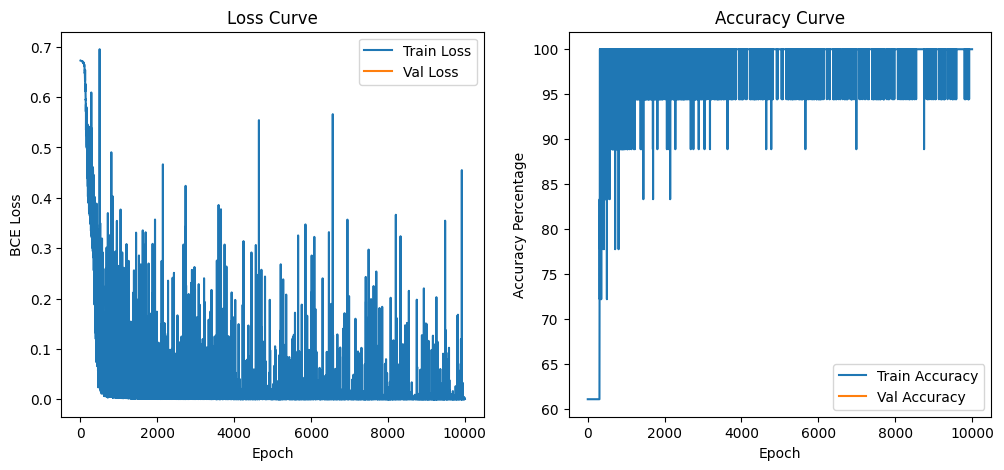

In [1039]:
import matplotlib.pyplot as plt

train_loss = [r["loss"] for r in training_steps]
val_loss = [r["loss"] for r in validation_steps]

train_acc = [r["acc"] for r in training_steps]
val_acc = [r["acc"] for r in validation_steps]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Percentage")
plt.legend()

In [1040]:

test_metrics = test_step(
    model=model_01,
    dataloader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
    validation=False
)
print(test_metrics)

Epoch Testing --> loss_avg=0.3946 , acc_avg=50.0000% :: time=0.01s
{'loss': 0.39461255073535995, 'acc': 50.0, 'time': 0.006540832982864231}


In [1041]:
def predict(model, X, device="cpu", threshold=0.5):
    model.eval()
    model.to(device)

    X = torch.tensor(X, dtype=torch.float32).to(device)

    with torch.inference_mode():
        logits = model(X)
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()

    return probs.cpu().numpy(), preds.cpu().numpy()

In [1074]:
import numpy as np

sample_encoded = [0.3, # GSR_Values
                  1.0,  #Cognitive_State: "Distracted": 1.0, "Cognitive Overload": 2.0, "Focused": 0.0
                  1.0,  #Emotional_State: "Anxious": 1.0, "Stressed": 2.0, "Calm": 0.0
                  2.0]  #Session_Type: "Study": 1.0, "Test": 2.0, "Relaxation": 0.0

sample_np = np.array(sample_encoded, dtype="float32").reshape(1, -1)

probs, preds = predict(model_01, sample_np, device=device)
print("Probability:", probs)
print("Prediction:", preds)
print("Label:", ("High Stressed" if probs > 0.5 else "Low Stressed"))

Probability: [3.6077745e-05]
Prediction: [0.]
Label: Low Stressed
